In [1]:
# imports
import polars as pl
import sys
import seaborn as sns
from scipy.stats import pearsonr

sys.path.append("..")
from src.utils import *

In [2]:
pl.Config.load_from_file("../polars_cfg.json")

In [3]:
# data file paths
clean_summary_path = "../data/clean_summary_data.csv"
clean_incomplete_path = "../data/clean_data_incomplete.csv"
clean_data_path = "../data/clean_data.csv"
clean_summary_incomplete_path = "../data/clean_summary_data_incomplete.csv"

In [4]:
df_summary = pl.read_csv(clean_summary_path)
df_summary_incomplete = pl.read_csv(clean_summary_incomplete_path)
df_all = pl.read_csv(clean_data_path)
df_incomplete = pl.read_csv(clean_incomplete_path)

# parse time
df_all = df_all.with_columns(pl.col("time").cast(pl.Datetime))
df_incomplete = df_incomplete.with_columns(pl.col("time").cast(pl.Datetime))

columns = [
    "exp_name",
    "hashed_id",
    "joint_id_task",
    "task_name",
    "task_number",
    "task_type",
    "attempt_number",
    "action",
    "num_actions",
    "solved",
    "time",
    "test_input_grid",
    "test_output_grid",
]

# include incomplete data
df_summary = pl.concat([df_summary, df_summary_incomplete])
df_all = pl.concat([df_all.select(columns), df_incomplete.select(columns)])

training_set = pl.read_csv("../data/ARC_training_tasks.csv")
evaluation_set = pl.read_csv("../data/ARC_evaluation_tasks.csv")

## Copy errors


In [5]:
def read_and_filter_tasks(file_path, example_type, example_number=None):
    df = pl.read_csv(file_path)
    if example_number is None:
        return df.filter(pl.col("example_type") == example_type)
    return df.filter(
        (pl.col("example_type") == example_type)
        & (pl.col("example_number") == example_number)
    )


def aggregate_grids(df):
    return df.group_by("task_name").agg(
        pl.col("input_grid").alias("input_grids"),
        pl.col("output_grid").alias("output_grids"),
    )


def process_task_set(file_path):
    train = read_and_filter_tasks(file_path, "train")
    test = read_and_filter_tasks(file_path, "test", 1)
    return aggregate_grids(train), aggregate_grids(test)


def add_copy_columns(df):
    return df.with_columns(
        pl.col("test_output_grid")
        .is_in("train_input_grids")
        .alias("train_input_grid_copy"),
        pl.col("test_output_grid")
        .is_in("train_output_grids")
        .alias("train_output_grid_copy"),
        pl.col("test_output_grid")
        .is_in("test_input_grids")
        .alias("test_input_grid_copy"),
        pl.col("test_output_grid")
        .is_in("test_output_grids")
        .alias("test_output_grid_copy"),
    )


def calculate_copy_rates(errors):
    total = errors.select(pl.sum("count")).item()
    copy_rates = {
        "train_input": errors.filter(pl.col("train_input_grid_copy"))
        .select(pl.sum("count"))
        .item(),
        "train_output": errors.filter(pl.col("train_output_grid_copy"))
        .select(pl.sum("count"))
        .item(),
        "test_input": errors.filter(pl.col("test_input_grid_copy"))
        .select(pl.sum("count"))
        .item(),
    }
    copy_rates["total"] = sum(copy_rates.values())
    return {k: v / total * 100 for k, v in copy_rates.items()}


def print_copy_rates(rates, set_name):
    print(f"{set_name} set:")
    print(f"Train input grid copy rate: {rates['train_input']:.1f}%")
    print(f"Train output grid copy rate: {rates['train_output']:.1f}%")
    print(f"Test input grid copy rate: {rates['test_input']:.1f}%")
    print(f"Total copy rate: {rates['total']:.1f}%")
    print()


# Main execution
training_train, training_test = process_task_set("../data/ARC_training_tasks.csv")
evaluation_train, evaluation_test = process_task_set("../data/ARC_evaluation_tasks.csv")

errors = get_errors(df_summary)

errors_training = errors.join(
    training_train.rename(
        {"input_grids": "train_input_grids", "output_grids": "train_output_grids"}
    ),
    on="task_name",
    how="inner",
)
errors_training = errors_training.join(
    training_test.rename(
        {"input_grids": "test_input_grids", "output_grids": "test_output_grids"}
    ),
    on="task_name",
    how="inner",
)

errors_evaluation = errors.join(
    evaluation_train.rename(
        {"input_grids": "train_input_grids", "output_grids": "train_output_grids"}
    ),
    on="task_name",
    how="inner",
)
errors_evaluation = errors_evaluation.join(
    evaluation_test.rename(
        {"input_grids": "test_input_grids", "output_grids": "test_output_grids"}
    ),
    on="task_name",
    how="inner",
)

errors_training = add_copy_columns(errors_training)
errors_evaluation = add_copy_columns(errors_evaluation)

training_copy_rates = calculate_copy_rates(errors_training)
evaluation_copy_rates = calculate_copy_rates(errors_evaluation)

print_copy_rates(training_copy_rates, "Training")
print_copy_rates(evaluation_copy_rates, "Evaluation")

Training set:
Train input grid copy rate: 0.6%
Train output grid copy rate: 2.4%
Test input grid copy rate: 7.0%
Total copy rate: 10.0%

Evaluation set:
Train input grid copy rate: 0.3%
Train output grid copy rate: 3.6%
Test input grid copy rate: 5.4%
Total copy rate: 9.2%



# Error divergence


In [6]:
mean_task_acc = pl.read_csv("../data/mean_task_acc_three_attempts.csv")
total_submissions = df_summary.group_by("task_name").agg(
    pl.len().alias("total_submissions")
)
mean_task_acc = mean_task_acc.join(total_submissions, on="task_name", how="inner")
task_error_divergence = errors.group_by("task_name").agg(
    (pl.len()).alias("error_divergence"), pl.first("task_type")
)
task_error_divergence = task_error_divergence.join(
    mean_task_acc.drop("task_type"), on="task_name", how="inner"
)
task_error_divergence = task_error_divergence.with_columns(
    pl.col("error_divergence") / pl.col("total_submissions")
)

Correlation between mean_solved and error_divergence for training tasks: -0.8088738687104776
Correlation between mean_solved and error_divergence for evaluation tasks: -0.8835221168734524


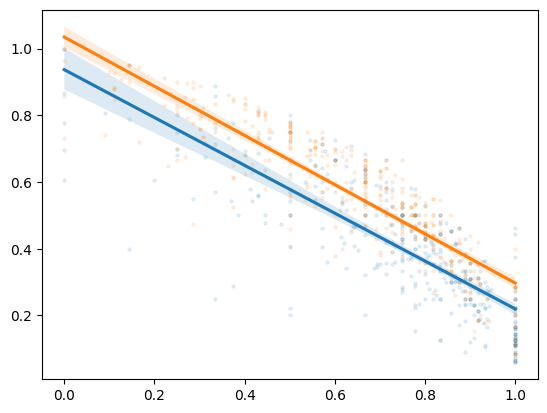

In [7]:
# plot error div as a function of task difficulty
sns.regplot(
    data=task_error_divergence.filter(pl.col("task_type") == "training"),
    x="mean_solved",
    y="error_divergence",
    scatter_kws={"alpha": 0.1, "s": 5},
)
sns.regplot(
    data=task_error_divergence.filter(pl.col("task_type") == "evaluation"),
    x="mean_solved",
    y="error_divergence",
    scatter_kws={"alpha": 0.1, "s": 5},
)
error_div_corr = (
    task_error_divergence.filter(pl.col("task_type") == "training")
    .select(pl.corr("mean_solved", "error_divergence"))
    .item()
)
print(
    f"Correlation between mean_solved and error_divergence for training tasks: {error_div_corr}"
)
error_div_corr = (
    task_error_divergence.filter(pl.col("task_type") == "evaluation")
    .select(pl.corr("mean_solved", "error_divergence"))
    .item()
)
print(
    f"Correlation between mean_solved and error_divergence for evaluation tasks: {error_div_corr}"
)

In [8]:
x, y = (
    task_error_divergence.filter(pl.col("task_type") == "training")
    .select("mean_solved", "error_divergence")
    .to_pandas()
    .values.T
)
corr, p_value = pearsonr(x, y)
print(
    f"Correlation between mean_solved and error_divergence for training tasks: {round(corr, 2)} (p-value: {round(p_value, 3)})"
)
print(f"Degrees of freedom: {len(x) - 2}")
x, y = (
    task_error_divergence.filter(pl.col("task_type") == "evaluation")
    .select("mean_solved", "error_divergence")
    .to_pandas()
    .values.T
)
corr, p_value = pearsonr(x, y)
print(
    f"Correlation between mean_solved and error_divergence for evaluation tasks: {round(corr, 2)} (p-value: {round(p_value, 3)})"
)
print(f"Degrees of freedom: {len(x) - 2}")

Correlation between mean_solved and error_divergence for training tasks: -0.81 (p-value: 0.0)
Degrees of freedom: 378
Correlation between mean_solved and error_divergence for evaluation tasks: -0.88 (p-value: 0.0)
Degrees of freedom: 395


# Dimension errors


In [9]:
errors = errors.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)
full_dataset = pl.concat([training_set, evaluation_set])
dim_errors = errors.select(
    "task_type",
    "task_name",
    "test_output_grid",
    "test_output_height",
    "test_output_width",
    "count",
).join(
    full_dataset.filter(
        (pl.col("example_type") == "test") & (pl.col("example_number") == 1)
    ).select("task_name", "output_height", "output_width"),
    on="task_name",
)
dim_errors = dim_errors.with_columns(
    (pl.col("test_output_height") == pl.col("output_height")).alias("height_match"),
    (pl.col("test_output_width") == pl.col("output_width")).alias("width_match"),
)
dim_errors = dim_errors.with_columns(
    ~(pl.col("height_match") & pl.col("width_match")).alias("dim_error")
)

In [10]:
dim_error_rate_training = (
    dim_errors.filter((pl.col("dim_error") & (pl.col("task_type") == "training")))
    .select(pl.sum("count"))
    .item()
    / dim_errors.filter((pl.col("task_type") == "training"))
    .select(pl.sum("count"))
    .item()
)
print(
    f"Dimension error rate on training set: {dim_error_rate_training * 100:.1f}% (correct: {100 - dim_error_rate_training*100:.1f}%)"
)
dim_error_rate_evaluation = (
    dim_errors.filter((pl.col("dim_error") & (pl.col("task_type") == "evaluation")))
    .select(pl.sum("count"))
    .item()
    / dim_errors.filter((pl.col("task_type") == "evaluation"))
    .select(pl.sum("count"))
    .item()
)
print(
    f"Dimension error rate on evaluation set: {dim_error_rate_evaluation * 100:.1f}% (correct: {100 - dim_error_rate_evaluation*100:.1f}%)"
)

Dimension error rate on training set: 31.8% (correct: 68.2%)
Dimension error rate on evaluation set: 26.5% (correct: 73.5%)


In [11]:
df_summary_errors = df_summary.filter(~pl.col("solved")).select(
    "task_name",
    "attempt_number",
    "test_output_grid",
)
df_summary_errors = df_summary_errors.join(
    dim_errors, on=["task_name", "test_output_grid"], how="left"
)

In [12]:
dim_error_rate_training_attempt_one = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 1)
        & (pl.col("task_type") == "training")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 1) & (pl.col("task_type") == "training")
    ).height
)

dim_error_rate_training_attempt_two = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 2)
        & (pl.col("task_type") == "training")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 2) & (pl.col("task_type") == "training")
    ).height
)

dim_error_rate_training_attempt_three = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 3)
        & (pl.col("task_type") == "training")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 3) & (pl.col("task_type") == "training")
    ).height
)

print(
    f"Dimension error rate on training set, attempt 1: {dim_error_rate_training_attempt_one * 100:.1f}%"
)
print(
    f"Dimension error rate on training set, attempt 2: {dim_error_rate_training_attempt_two * 100:.1f}%"
)

print(
    f"Dimension error rate on training set, attempt 3: {dim_error_rate_training_attempt_three * 100:.1f}%"
)
print()
dim_error_rate_evaluation_attempt_one = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 1)
        & (pl.col("task_type") == "evaluation")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 1) & (pl.col("task_type") == "evaluation")
    ).height
)

dim_error_rate_evaluation_attempt_two = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 2)
        & (pl.col("task_type") == "evaluation")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 2) & (pl.col("task_type") == "evaluation")
    ).height
)


dim_error_rate_evaluation_attempt_three = (
    df_summary_errors.filter(
        (pl.col("attempt_number") == 3)
        & (pl.col("task_type") == "evaluation")
        & pl.col("dim_error")
    ).height
    / df_summary_errors.filter(
        (pl.col("attempt_number") == 3) & (pl.col("task_type") == "evaluation")
    ).height
)

print(
    f"Dimension error rate on evaluation set, attempt 1: {dim_error_rate_evaluation_attempt_one * 100:.1f}%"
)
print(
    f"Dimension error rate on evaluation set, attempt 2: {dim_error_rate_evaluation_attempt_two * 100:.1f}%"
)
print(
    f"Dimension error rate on evaluation set, attempt 3: {dim_error_rate_evaluation_attempt_three * 100:.1f}%"
)

Dimension error rate on training set, attempt 1: 30.9%
Dimension error rate on training set, attempt 2: 31.5%
Dimension error rate on training set, attempt 3: 33.8%

Dimension error rate on evaluation set, attempt 1: 24.8%
Dimension error rate on evaluation set, attempt 2: 27.0%
Dimension error rate on evaluation set, attempt 3: 28.3%


# Error statistics


In [13]:
arc_tests = pl.read_csv("../data/ARC_all_tasks_tests_stats.csv").drop(
    "example_type", "example_number", "input_filename", "output_filename", "set"
)
arc_training = pl.read_csv("../data/ARC_training_tasks.csv")
arc_evaluation = pl.read_csv("../data/ARC_evaluation_tasks.csv")

People seem to be resorting to patterns in


In [14]:
arc_tests.head()

task_type,task_number,task_name,input_height,input_width,output_height,output_width,input_grid,output_grid,grid_size,num_examples
str,i64,str,i64,i64,i64,i64,str,str,i64,i64
"""training""",1,"""007bbfb7.json""",3,3,9,9,"""|707|707|770|""","""|707000707|707000707|770000770|707000707|7070…",81,5
"""training""",2,"""00d62c1b.json""",20,20,20,20,"""|00000000000000000000|00300000000000000000|03…","""|00000000000000000000|00300000000000000000|03…",400,5
"""training""",3,"""017c7c7b.json""",6,3,9,3,"""|111|010|010|111|010|010|""","""|222|020|020|222|020|020|222|020|020|""",27,3
"""training""",4,"""025d127b.json""",10,10,10,10,"""|0000000000|0444444000|0400000400|0040000040|…","""|0000000000|0044444400|0040000040|0004000004|…",100,2
"""training""",5,"""045e512c.json""",21,21,21,21,"""|000000000000000000000|000000000000000000000|…","""|000000000000004040000|000000000000004040000|…",441,3


In [15]:
errors.head()

task_name,test_output_grid,count,task_type,hashed_output_grid,test_output_height,test_output_width
str,str,u32,str,str,u32,u32
"""10fcaaa3.json""","""|03000|88888|88888|00030|88888|03000|""",1,"""training""","""726a955fdc375d1ac906ed7744e2f643""",6,5
"""77fdfe62.json""","""|0000000040|3011111144|0108800010|0188808010|…",1,"""training""","""d825d0cc2b2458d287725b732d074aee""",10,10
"""7c9b52a0.json""","""|0003|4443|6402|6622|""",1,"""evaluation""","""2cf652eaa57b1ca55a307aad9742000b""",4,4
"""b942fd60.json""","""|000|050|050|""",1,"""evaluation""","""e75680534f32d3742b3b3316165f3ee5""",3,3
"""0934a4d8.json""","""|6966|9399|3499|1941|""",2,"""evaluation""","""d34180f9fd4ecba53b3e370b3818fee3""",4,4
